Setting a SARIMA model simple and with features (customers)

In [1]:
import pandas as pd
import numpy as np

from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf

import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

from itertools import product
#to generate all possible product

from sklearn.metrics import mean_absolute_percentage_error

from tqdm.notebook import tqdm
#Study the use of this library

#file importation sales in kg
sales_hn_kg = pd.read_csv("sales_hn_kg.csv")


In [2]:
#date column as date type
sales_hn_kg["Sales_Time"] = pd.to_datetime(sales_hn_kg["Sales_Time"],format = "%Y-%m-%d")
sales_hn_kg["year"] = sales_hn_kg["Sales_Time"].dt.year
sales_kg_train = sales_hn_kg[sales_hn_kg["Sales_Time"]<"2023-05-01"]
sales_kg_test = sales_hn_kg[sales_hn_kg["Sales_Time"]>="2023-05-01"]
#groupby date and sum of the kg
sales_gr_train = sales_kg_train.groupby("Sales_Time").agg({"KG" : "sum", "cust_group": "nunique", "item": "nunique"})
sales_gr_train = pd.DataFrame(data = sales_gr_train)

sales_gr_test = sales_kg_test.groupby("Sales_Time").agg({"KG" : "sum", "cust_group": "nunique", "item": "nunique"})
sales_gr_test = pd.DataFrame(data = sales_gr_test)



In [117]:
sales_kg_train

,Sales_Time,level3,cust_group,item,KG,year
0,2018-06-01,Health,975,70001855,500.0,2018
1,2018-08-01,Health,975,70001855,200.0,2018
2,2018-09-01,Health,975,70001855,150.0,2018
3,2018-11-01,Health,975,70001855,50.0,2018
4,2018-04-01,Health,975,70001859,1000.0,2018
...,...,...,...,...,...,...
22395,2023-02-01,Health,20279,70010565,24.0,2023
22396,2023-04-01,Health,20279,70010565,25.0,2023
22397,2023-01-01,Health,7013796,70002791,50.0,2023
22399,2023-01-01,Health,7013796,70001963,25.0,2023


The residu is not white, so it's a multiplicative model, using log we will use it as an additive model
In addition, we can detect the seasonality in 12 periods


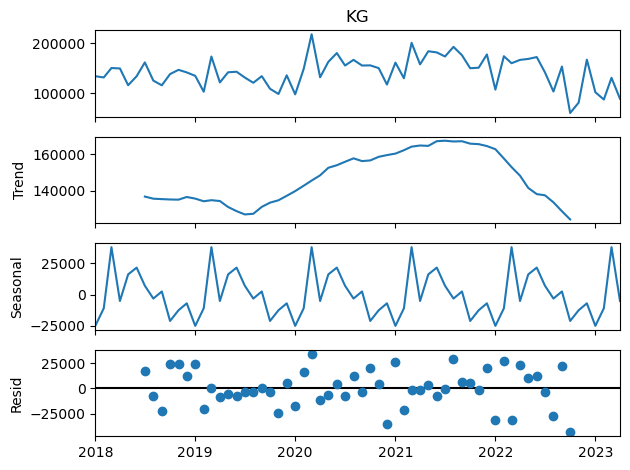

In [3]:
# Decomposition des series pour savoir quel est le modele

res = seasonal_decompose(sales_gr_train["KG"])
res.plot();

print("The residu is not white, so it's a multiplicative model, using log we will use it as an additive model")
print("In addition, we can detect the seasonality in 12 periods")

p_value =  1.7844873145083034e-21
p_value < 5%, the serie is stationnare


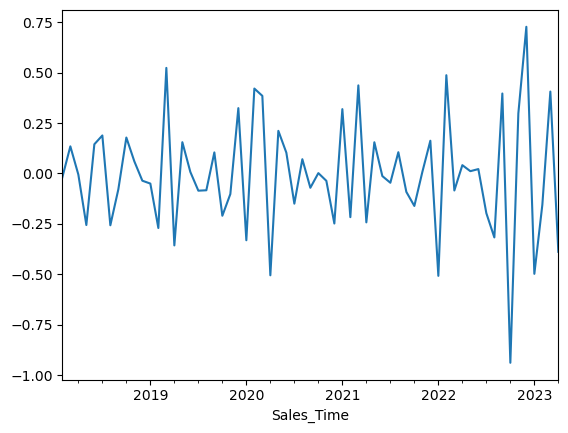

In [4]:

# model is multiplicative so we apply the log
sales_train_log = np.log(sales_gr_train)
sales_train_log1 = sales_train_log.diff().dropna()

#Finalyy, to be sure of the stationarity we perform the ADF test
_,p_value,_,_,_,_ = sm.tsa.stattools.adfuller(sales_train_log1["KG"])

print("p_value = ",p_value)
print("p_value < 5%, the serie is stationnare")

#visualization of the serie
sales_train_log1["KG"].plot();

From the previous analysis we can define: d=1, k=12, D=1
Small seasonality on 12, but still detectable, so Q=1


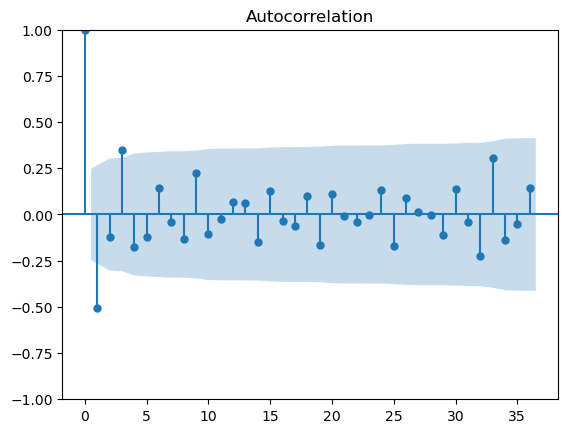

In [5]:
# SARIMA model application
# SARIMA(p,d,q)(P,D,Q)k
#From the previous analysis we can define: d=1, k=12, D=1
#For the others parameters we are going to use to correlation ACF


plot_acf(sales_train_log1["KG"], lags = 36);

print("From the previous analysis we can define: d=1, k=12, D=1")
print("Small seasonality on 12, but still detectable, so Q=1")

Function that will test a series of parameters for the SARIMA model and output a table with the best performing model

def optimize_SARIMA(parameters_list, endog, test):
    """
        Return Df with all the coeff tested, AIC and max p_value filtred at <5%
        Also calculate for each model the Mean Absolute Percentage Error

        It's a combination of all possible coeff and main parameters during the fit process
        WARNING: for the moment only for multiplictive model, using np.exp during the prediction step
    """
    #start and end for prediction period
    start = endog.shape[0]
    end = endog.shape[0]+test.shape[0]-1

    results = []
    
    for param in tqdm(parameters_list):
        try: 
            model = sm.tsa.SARIMAX(endog, 
                                   order=(param[0], param[1], param[2]), 
                                   seasonal_order=(param[3], param[4], param[5], param[6])
                                   ).fit(disp=-1, 
                                         cov_type=param[7], 
                                         method=param[8], 
                                         )
        except:
            continue
   
   #results of the model SARIMA         
        aic = model.aic
        len_pvalue = len(model.pvalues)
        
        p_value = {}
        for i in range(0,len_pvalue,1):
             p_val = model.pvalues[i].round(3)
             name = model.pvalues.index[i]
             p_value[name] = p_val
    
    #prediction + calculation of the Mean Absolute Percentage Error
        #WARNING change the method to be used with additive model (no log necessary)
        try:
            prediction = np.exp(model.predict(start,end)).round(3)
            mape_model = mean_absolute_percentage_error(test, prediction).round(3)
            
        except:
            mape_model = 1
    # all the necesary outputs in results    
        results.append([param, aic, model.pvalues.max(), mape_model, p_value])

    #creation of the DF with all the results, filtering on the p_value and selecting the min AIC.    
    result_df = pd.DataFrame(results)
    result_df.columns = ['(p,d,q)x(P,D,Q,k)', 'AIC', "max p_values", "p-values"]
    
    #Sort in ascending order, lower AIC is better
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    result_df = result_df[result_df["max p_values"] >= 0.05]

    best_params = result_df.iloc[0]['(p,d,q)x(P,D,Q,k)'] # we take only the first line, it has the max AIC and coeff p-value <5%
    #best_params = best_params["(p,d,q)x(P,D,Q,k)"][0] # we transform the Df in a tuple to allow extract all the values for the model training ((p,d,q)x(P,D,Q,k))
    
    return result_df, best_params

In [8]:
def optimize_SARIMA(parameters_list, endog, test):
    """
        Return Df with all the coeff tested, AIC and max p_value filtred at <5%
        Also calculate for each model the Mean Absolute Percentage Error

        It's a combination of all possible coeff and main parameters during the fit process
        WARNING: for the moment only for multiplictive model, using np.exp during the prediction step
    """
    #start and end for prediction period
    start = endog.shape[0]
    end = endog.shape[0]+test.shape[0]-1

    results = []
    
    for param in tqdm(parameters_list):
        try:
            model = sm.tsa.SARIMAX(endog, 
                                   order=(param[0], param[1], param[2]), 
                                   seasonal_order=(param[3], param[4], param[5], param[6]),
                                   simple_differencing=False,
                                   ).fit(disp= False, #remove optimization messages 
                                         method=param[7], 
                                         low_memory=True,
                                         method_kwarg={"warn_convergence":False} #to remove the warning messages
                                         )    
        except:
            continue
   
   #results of the model SARIMA         
        aic = model.aic
        len_pvalue = len(model.pvalues)
        
        #using to_dict to simplify the for loop
        p_value = {name: round(pval,3) for name, pval in model.pvalues.items()}
    
    #prediction + calculation of the Mean Absolute Percentage Error
        #WARNING change the method to be used with additive model (no log necessary)
        prediction = np.exp(model.predict(start,end)).round(3)
        mape_model = (np.abs((test - prediction) / test) * 100).mean(axis = 0)
        
    # all the necesary outputs in results    
        results.append([param, round(aic,3), round(model.pvalues.max(),3), round(mape_model,3), p_value])

    #creation of the DF with all the results, filtering on the p_value and selecting the min AIC.    
    result_df = pd.DataFrame(results)
    result_df.columns = ['(p,d,q)x(P,D,Q,k),method', 'AIC', "max p_values", "MAPE", "p-values"]
    
    #Sort in ascending order, lower AIC is better
    result_df = result_df.sort_values(by='AIC', ascending=True)
    result_df = result_df.sort_values(by='MAPE', ascending=True).reset_index(drop=True)
    #result_df = result_df[result_df["max p_values"] >= 0.05]

    best_params = result_df.iloc[:1,:1] # we take only the first line, it has the max AIC and coeff p-value <5%
    best_params = best_params["(p,d,q)x(P,D,Q,k),method"][0] # we transform the Df in a tuple to allow extract all the values for the model training ((p,d,q)x(P,D,Q,k))
    
    return result_df, best_params


#Definition of the parameters for order and seasonal order
p = [0,1,2]
d = [0,1]
q = [0,1,2]
P = [0,1,2]
D = [0,1]
Q = [0,1,2]
k = [6,12]
#Definition of the parameters for fit
cov_type = ["non", "opg", "oim", "approx", "robust", "robust_approx"]
method = ["newton", "nm", "bfgs", "lbfgs", "powell", "cg", "ncg", "basinhopping"]

#generate all possible combinations

parameters = product(p, d, q, P, D, Q, k, cov_type, method)
parameters_list = list(parameters)
print(len(parameters_list))


In [9]:

#Definition of the parameters for order and seasonal order
p = [0,1,2,3]
d = [0,1]
q = [0,1,2,3]
P = [0,1,2,3]
D = [0,1,2]
Q = [0,1,2,3]
k = [12]

#Definition of the parameters for fit
method = ["nm", "bfgs", "lbfgs", "powell", "cg", "ncg", "basinhopping"]

#generate all possible combinations

parameters = product(p, d, q, P, D, Q, k, method)
parameters_list = list(parameters)
print(len(parameters_list))


10752


In [10]:
#Using the function with the data per kg

result_df, best_params = optimize_SARIMA(parameters_list, sales_train_log["KG"], sales_gr_test["KG"])
p, d, q, P, D, Q, k, method = best_params
result_df.head(30)

  0%|          | 0/10752 [00:00<?, ?it/s]

In [104]:
result_df.to_csv("sarimax_optimization_result.csv", index = False)

In [6]:
#Now we can run SARIMA with the best parameters for AIC and p_value and follow the analysis
sarima_best = sm.tsa.SARIMAX(sales_train_log["KG"], order = (p,d,q), seasonal_order = (P,D,Q,k)).fit(method = method)
print(sarima_best.summary()) 

NameError: name 'p' is not defined

In [19]:
#Now we can run SARIMA with the best parameters for AIC and p_value and follow the analysis
sarima_best = sm.tsa.SARIMAX(sales_train_log["KG"], order = (2,1,0), seasonal_order = (1,0,1,6)).fit(method = "lbfgs")
print(sarima_best.summary()) 

                                      SARIMAX Results                                      
Dep. Variable:                                  KG   No. Observations:                   64
Model:             SARIMAX(2, 1, 0)x(1, 0, [1], 6)   Log Likelihood                   9.272
Date:                             Tue, 28 May 2024   AIC                             -8.544
Time:                                     14:28:02   BIC                              2.172
Sample:                                 01-01-2018   HQIC                            -4.329
                                      - 04-01-2023                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8130      0.100     -8.137      0.000      -1.009      -0.617
ar.L2         -0.5448      

In [7]:
pd.read_csv("sarimax_optimization_result.csv")

,"(p,d,q)x(P,D,Q,k),method",AIC,max p_values,MAPE,p-values
0,"(2, 1, 0, 1, 0, 1, 12, 'powell')",-6.963,0.205,2.123400e+01,"{'ar.L1': 0.0, 'ar.L2': 0.0, 'ar.S.L12': 0.023..."
1,"(2, 1, 0, 1, 0, 1, 12, 'basinhopping')",-6.964,0.200,2.124900e+01,"{'ar.L1': 0.0, 'ar.L2': 0.0, 'ar.S.L12': 0.021..."
2,"(2, 1, 0, 1, 0, 1, 12, 'bfgs')",-6.964,0.201,2.124900e+01,"{'ar.L1': 0.0, 'ar.L2': 0.0, 'ar.S.L12': 0.021..."
3,"(2, 1, 0, 1, 0, 1, 12, 'lbfgs')",-6.964,0.200,2.125000e+01,"{'ar.L1': 0.0, 'ar.L2': 0.0, 'ar.S.L12': 0.021..."
4,"(2, 1, 1, 2, 0, 2, 12, 'bfgs')",-1.191,0.866,2.127100e+01,"{'ar.L1': 0.001, 'ar.L2': 0.002, 'ma.L1': 0.86..."
...,...,...,...,...,...
2017,"(0, 1, 0, 2, 0, 0, 6, 'newton')",6.000,0.806,4.043046e+77,"{'ar.S.L6': 0.806, 'ar.S.L12': nan, 'sigma2': ..."
2018,"(0, 1, 1, 2, 0, 1, 6, 'newton')",81.435,0.000,2.243866e+93,"{'ma.L1': nan, 'ar.S.L6': nan, 'ar.S.L12': 0.0..."
2019,"(0, 1, 2, 2, 0, 0, 6, 'newton')",254.464,0.000,4.201299e+235,"{'ma.L1': nan, 'ma.L2': nan, 'ar.S.L6': 0.0, '..."
2020,"(2, 1, 0, 1, 1, 1, 6, 'newton')",266.769,0.000,inf,"{'ar.L1': 0.0, 'ar.L2': 0.0, 'ar.S.L6': nan, '..."


In [ ]:

#Definition of the parameters for order and seasonal order
p = [0,1,2]
d = [0,1]
q = [0,1,2]
P = [0,1,2]
D = [0,1]
Q = [0,1,2]
k = [6,12]
#Definition of the parameters for fit
cov_type = ["opg", "oim", "approx", "robust", "robust_approx"]
method = ["newton", "nm", "bfgs", "lbfgs", "powell", "cg", "ncg", "basinhopping"]

#generate all possible combinations

parameters = product(p, d, q, P, D, Q, k, cov_type, method)
parameters_list = list(parameters)
print(len(parameters_list))


25920


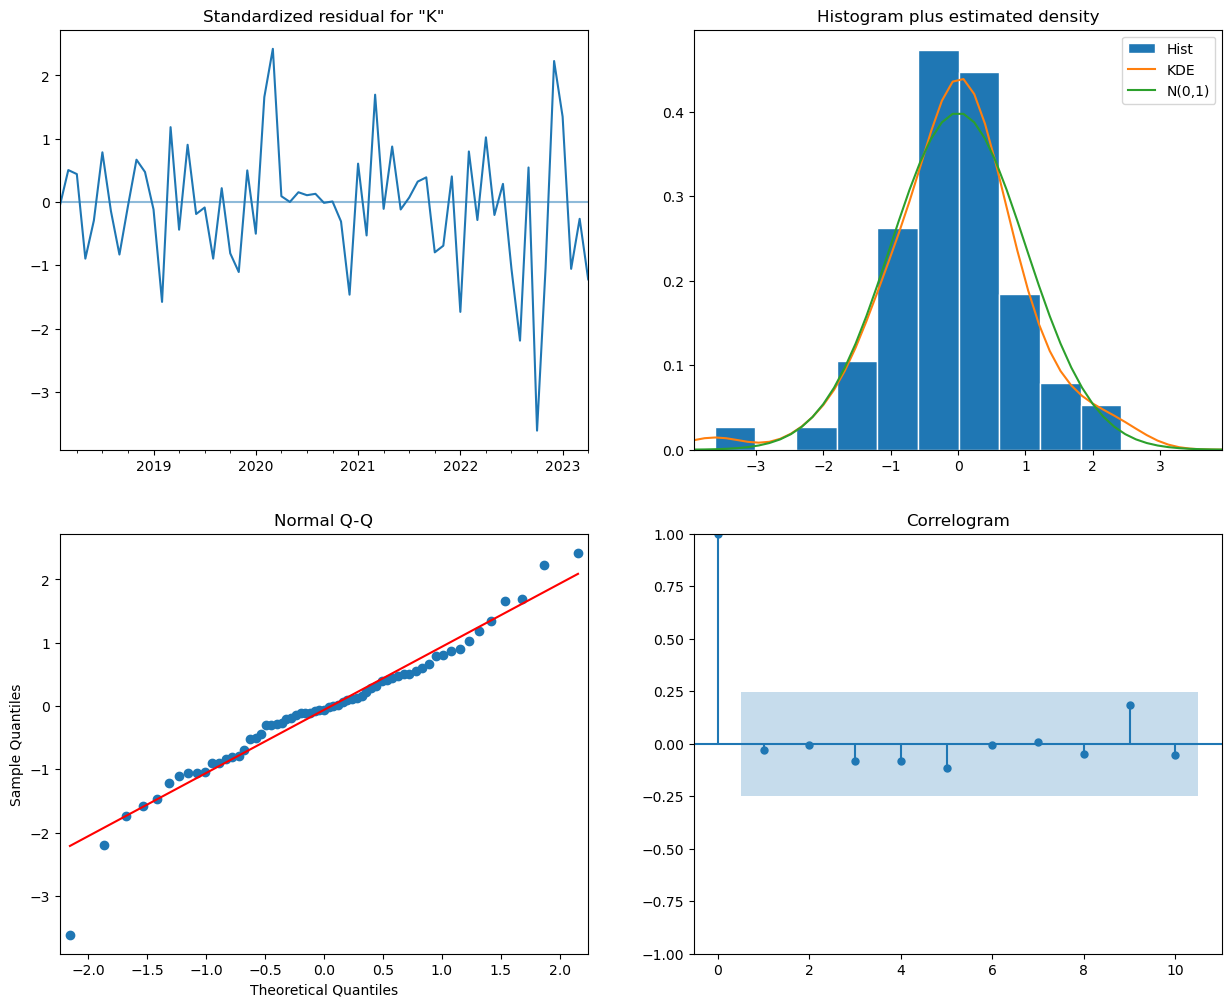

In [20]:
# graph residual analysis, same conclusion
sarima_best.plot_diagnostics(figsize=(15,12));

Now we can forecast this model in the test period and compare with the actual data

Mean Absolute Percentage Error as percentage: 23.19%


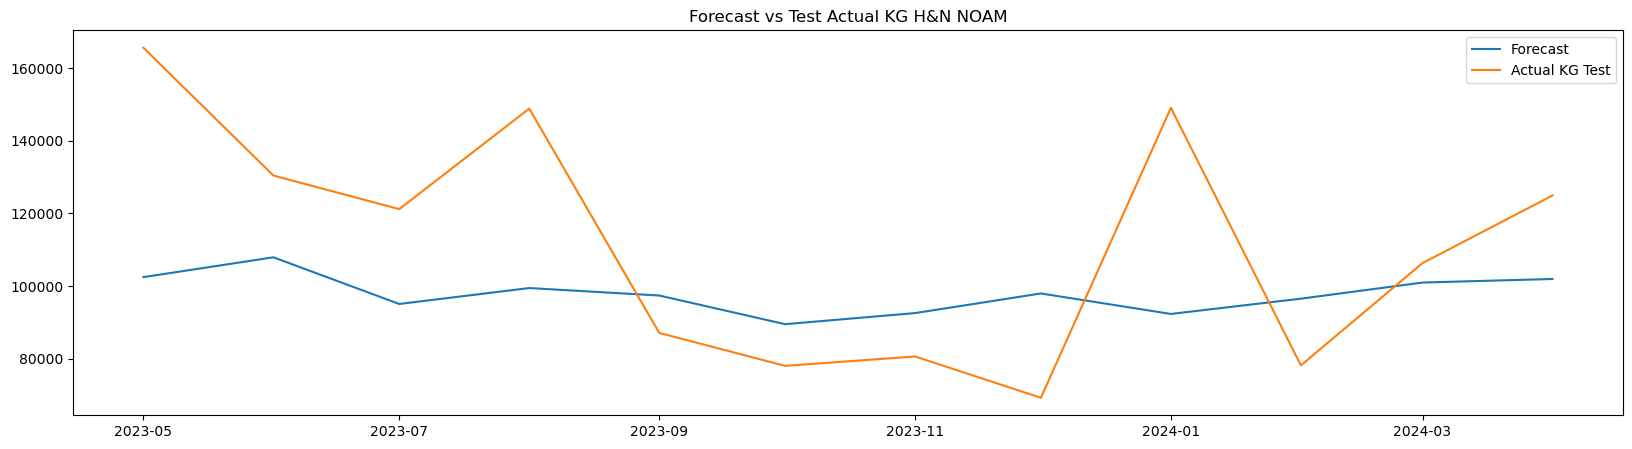

In [21]:
#Prediction on actual period to compare and futur period
forecast = np.exp(sarima_best.predict(sales_gr_train.shape[0],sales_gr_train.shape[0]+sales_gr_test.shape[0]-1))

plt.figure(figsize = (20,5))
plt.plot(forecast, label = "Forecast")
plt.plot(sales_gr_test["KG"], label = "Actual KG Test")
plt.title("Forecast vs Test Actual KG H&N NOAM")
plt.legend();

#Evaluation of the model accuracy per month using the MAPE, as it's a % it will be easier to communicate

mape_sarima_month = mean_absolute_percentage_error(sales_gr_test["KG"], forecast)*100
print(f"Mean Absolute Percentage Error as percentage: {mape_sarima_month:.2f}%")


In [158]:
#Error analysis on total year
#actual
actual_test_year = sales_kg_test.groupby("year")["KG"].sum()

#forecast
forecast_test_year = pd.DataFrame(forecast).reset_index()
forecast_test_year["year"] = forecast_test_year["index"].dt.year
forecast_test_year = forecast_test_year.groupby("year")["predicted_mean"].sum()

Mean Absolute Percentage Error as percentage: 13.06%


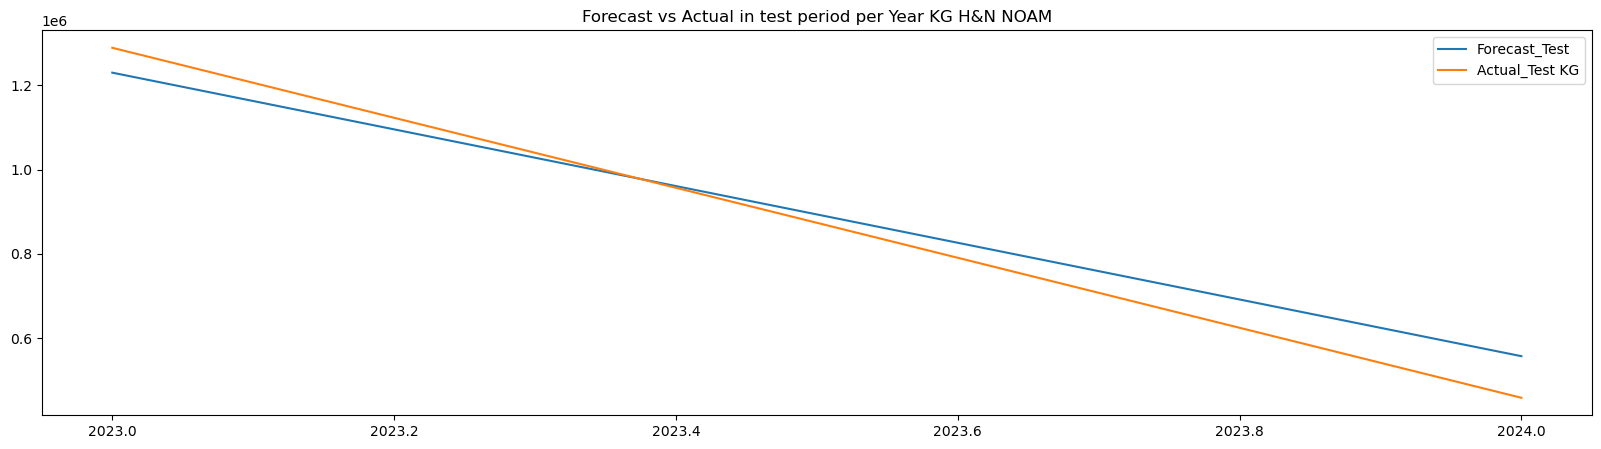

In [159]:
plt.figure(figsize = (20,5))
plt.plot(forecast_test_year, label = "Forecast_Test")
plt.plot(actual_test_year, label = "Actual_Test KG")
plt.title("Forecast vs Actual in test period per Year KG H&N NOAM")
plt.legend();

#Evaluation of the model accuracy per year using the MAPE, as it's a % it will be easier to communicate
mape_sarima_year = mean_absolute_percentage_error(actual_test_year, forecast_test_year)*100
print(f"Mean Absolute Percentage Error as percentage: {mape_sarima_year:.2f}%")

Now we are going to add the number of customers and references by month, in order to see if we improve this model adding features

In [44]:
#We define a function for SARIMAX
def optimize_SARIMAX(parameters_list, d, D, s, endog, exog):
    """
        Return dataframe with parameters, corresponding AIC and SSE
        
        parameters_list - list with (p, q, P, Q) tuples
        exog - the exogenous variable
    """
    
    results = []
    
    for param in tqdm(parameters_list):
        try: 
            model = sm.tsa.SARIMAX(endog = endog, exog = exog, order=(param[0], d, param[1]), seasonal_order=(param[2], D, param[3], s)).fit(disp=-1)
        except:
            continue
            
        aic = model.aic
        results.append([param, aic])
        
    result_df = pd.DataFrame(results)
    result_df.columns = ['(p,q)x(P,Q)', 'AIC']
    #Sort in ascending order, lower AIC is better
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    
    return result_df

In [48]:
#Using the function with the data per kg

result_sarimax = optimize_SARIMAX(parameters_list, d, D, s, sales_gr1_log["KG"], sales_gr1[["cust_group","item"]])
result_sarimax

  0%|          | 0/256 [00:00<?, ?it/s]

,"(p,q)x(P,Q)",AIC
0,"(0, 2, 0, 1)",-5.487054
1,"(1, 1, 0, 1)",-5.485300
2,"(1, 1, 2, 0)",-4.197342
3,"(2, 0, 0, 1)",-4.174790
4,"(0, 2, 2, 0)",-4.077204
...,...,...
251,"(0, 0, 2, 3)",37.477197
252,"(0, 0, 0, 1)",38.384605
253,"(0, 0, 3, 3)",39.283679
254,"(0, 0, 1, 0)",47.790968


In [72]:
#Now we can run SARIMA with the best parameters for AIC and follow the analysis
#In order to compare the SARIMA models we use the same parameters
#time_varying_regression: exogenous regressors are allowed to vary over time
# mle_regression: Whether or not to use estimate the regression coefficients for the exogenous variables as part of maximum likelihood estimation or through the Kalman filter (i.e. recursive least squares). If time_varying_regression is True, this must be set to False.
sarimax_best = sm.tsa.SARIMAX(endog = sales_gr1_log["KG"], 
                              exog = sales_gr1[["cust_group","item"]], 
                              order = (2,1,0), 
                              seasonal_order = (0,1,1,12), 
                              ).fit()
print(sarimax_best.summary()) 
print("The residual is following the normal law (Prob JB > 5%) and is aleatory (Prob Q > 5%)")
print("The features are not significant with a p-value>5%, but let's calculate the forecast")

                                      SARIMAX Results                                       
Dep. Variable:                                   KG   No. Observations:                   76
Model:             SARIMAX(2, 1, 0)x(0, 1, [1], 12)   Log Likelihood                   8.087
Date:                              Fri, 24 May 2024   AIC                             -4.175
Time:                                      15:25:38   BIC                              8.684
Sample:                                  01-01-2018   HQIC                             0.883
                                       - 04-01-2024                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
cust_group     0.0048      0.003      1.546      0.122      -0.001       0.011
item           0.00

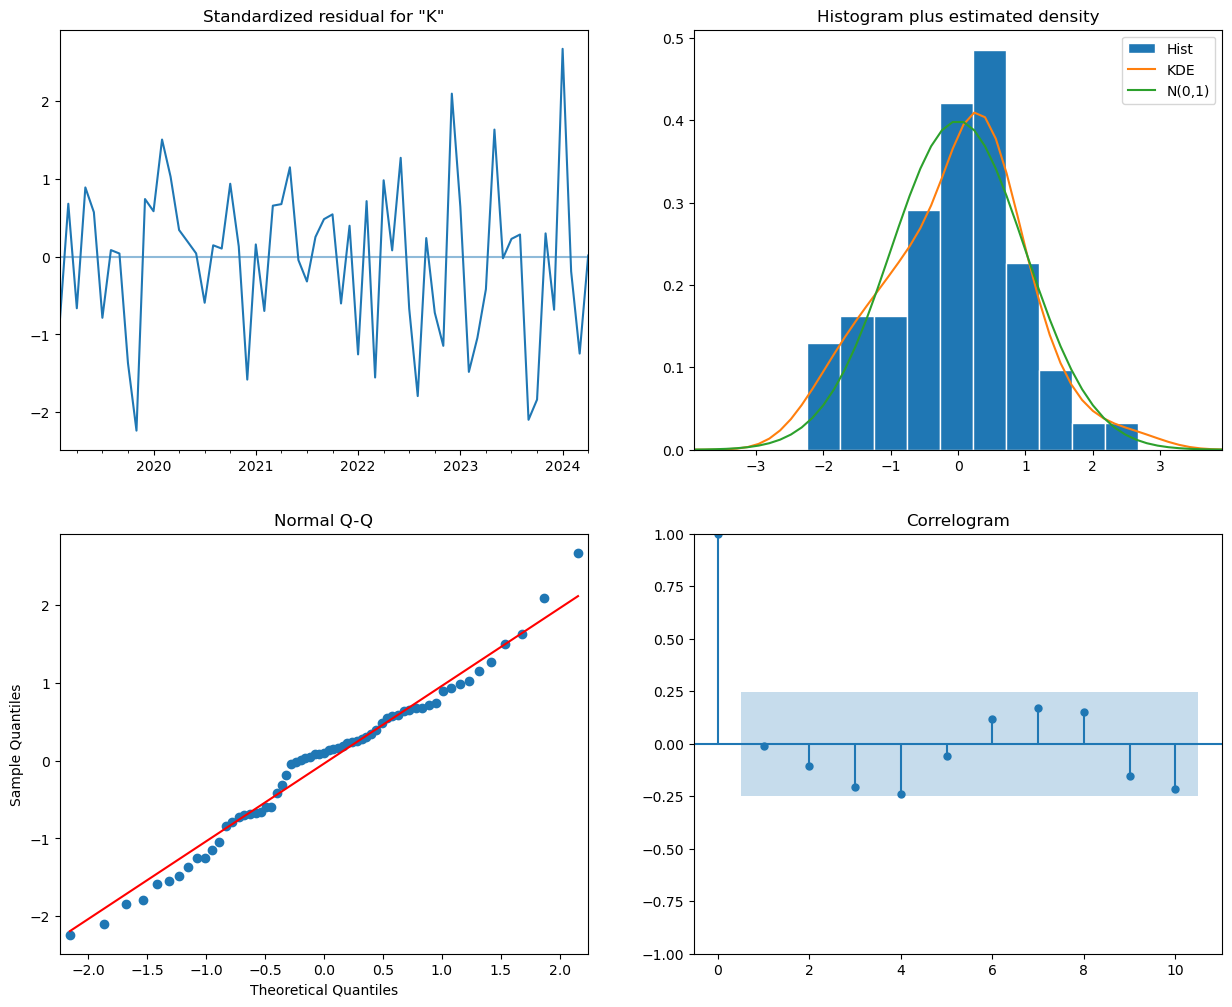

In [66]:
# graph residual analysis, same conclusion
sarimax_best.plot_diagnostics(figsize=(15,12));

In [73]:
#Prediction on actual period
forecast_x = np.exp(sarimax_best.predict(start = sales_gr1.shape[0]-60,end = sales_gr1.shape[0], exog = sales_gr1[["cust_group", "item"]]))

plt.figure(figsize = (20,5))
plt.plot(forecast_x, label = "Forecast")
plt.plot(sales_gr1["KG"], label = "Actual KG")

plt.title("Forecast vs Actual KG H&N NOAM")
plt.legend()

plt.figure(figsize = (20,3))
plt.plot(sales_gr1["cust_group"], label = "customer unique nb")
plt.plot(sales_gr1["item"], label = "item unique nb")
plt.title("Customer and Item unique count per month")
plt.legend();

#Evaluation of the model accuracy per month using the MAPE, as it's a % it will be easier to communicate
mape_sarimax_month = mean_absolute_percentage_error(sales_gr1["KG"][-60:], forecast_x[:-31])*100
print(f"Mean Absolute Percentage Error as percentage: {mape_sarimax_month:.2f}%")

ValueError: Provided exogenous values are not of the appropriate shape. Required (1, 2), got (76, 2).